# Goal

data document: https://docs.google.com/document/d/1zj-yIR7s7-MWEk3u9O1kQTfL0d6bF0Yz1H_CV-n1T4U/edit#

In [2]:
%%capture
!pip install mwclient
!pip install mwviews

from itertools import islice

def window_seq(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result
        
def wmftimestamp(bytestring):
    if bytestring:
        s = bytestring.decode('utf-8')
        return dt.strptime(s, '%Y%m%d%H%M%S')
    else:
        return bytestring
    

def decode_or_nouser(b):
    return b.decode('utf-8') if b else '#nosuchuser'

!mkdir outputs
!mkdir checkpoints


import json
import requests

from sqlalchemy import create_engine
from sqlalchemy.exc import ProgrammingError
from pymysql.err import InternalError, OperationalError
import sys, os
import pandas as pd
import numpy as np

import mwclient
import mwviews

from datetime import datetime as dt
from datetime import timedelta as td

%pylab inline

langs = ['ar', 'fa', 'pl']

langcode = langs[0]

datadir = os.path.join('data', langcode)


site = mwclient.Site(('https', f'{langcode}.wikipedia.org'), path = '/w/')

os.makedirs(datadir, exist_ok=True)

constr = 'mysql+pymysql://{user}:{pwd}@{host}/DB?charset=utf8'.format(user=os.environ['MYSQL_USERNAME'],
                                                      pwd=os.environ['MYSQL_PASSWORD'],
                                                      host=os.environ['MYSQL_HOST'])

con = create_engine(constr, encoding='utf-8')


con.execute(f'use enwiki_p;')


# Wednesday  Mar 7 2018 (mid week)
# Saturday March 24 2018 (beginning weekend)

sim_onboard_start_dates = (dt(2018,3,7), dt(2018,3,24))
sim_onboard_start_date = sim_onboard_start_dates[0]
onboard_days= 90
observation_days=90
sim_onboard_end_date = sim_onboard_start_date + td(days=onboard_days)
sim_experiment_end_date = sim_onboard_start_date + td(days=onboard_days+observation_days)

lang = 'fr'

In [4]:
def get_registered_users(lang, start_date, end_date):
    db_prefix = f'{lang}wiki_p'
    con.execute(f'use {db_prefix}')
    reg_sql = '''
select u.user_id, u.user_name, u.user_registration, p.up_property, p.up_value
from user u
left join user_properties p
on p.up_user = u.user_id
where user_registration > {start} and user_registration < {end}
;'''.format(start=start_date.strftime('%Y%m%d%H%M%S'),
           end=end_date.strftime('%Y%m%d%H%M%S'))
#     print(reg_sql)
    reg_df = pd.read_sql(reg_sql, con)
    reg_df['user_registration'] = reg_df['user_registration'].apply(wmftimestamp)
    return reg_df

In [5]:
df = get_registered_users(lang, sim_onboard_start_date, sim_onboard_end_date)

In [6]:
df.head()

,user_id,user_name,user_registration,up_property,up_value
0,3060196,b'Caporal10',2018-03-07 00:02:14,None,None
1,3060197,b'Cosmokdjfjdjdjhxhdjdb',2018-03-07 00:04:25,None,None
2,3060198,b'Bangaly konat\xc3\xa9',2018-03-07 00:04:34,None,None
3,3060199,b'Diassynthesis',2018-03-07 00:09:06,None,None
4,3060200,b'Supremeboi88',2018-03-07 00:10:17,None,None


In [7]:
df['up_property'].value_counts()

b'gender'         232
b'nickname'       215
b'fancysig'       129
b'disablemail'     84
Name: up_property, dtype: int64

In [8]:
df['up_value'].value_counts()[:5]

b'1'                  213
b'male'               169
b'female'              63
b'Gilles BERTHIER'      1
b'nadia nad30'          1
Name: up_value, dtype: int64

In [9]:
df.shape

(82306, 5)

In [10]:
def property_columns(user_df):
    props = list(user_df['up_property'])
    has_email = False if b'disablemail' in props else True
    has_gender = user_df[user_df['up_property']==b'gender']['up_value'].iloc[0].decode('utf-8') if b'gender' in props else 'not_set'
    user_name = user_df['user_name'].iloc[0].decode('utf-8')
    return pd.DataFrame.from_dict({'user_name':user_name,'has_email':has_email,'has_gender':has_gender}, orient='index').T

In [11]:
users = df.groupby('user_id').apply(property_columns)

In [12]:
users = users.reset_index()

In [13]:
del users['level_1']

In [14]:
users['has_email'].value_counts()

True     82040
False       84
Name: has_email, dtype: int64

In [15]:
users['has_gender'].value_counts()

not_set    81892
male         169
female        63
Name: has_gender, dtype: int64

In [16]:
users = users.merge(df[['user_id','user_registration']], how='left')

In [17]:
users['sim_observation_end'] = users['user_registration'].apply(lambda d: d+td(days=onboard_days))

In [18]:
users.tail()

,user_id,user_name,has_email,has_gender,user_registration,sim_observation_end
82301,3143206,Pchayer,True,not_set,2018-06-04 23:45:50,2018-09-02 23:45:50
82302,3143207,Foxxyangel,True,not_set,2018-06-04 23:53:26,2018-09-02 23:53:26
82303,3143208,Osquiabro,True,not_set,2018-06-04 23:53:39,2018-09-02 23:53:39
82304,3143209,Scictieddo,True,not_set,2018-06-04 23:59:18,2018-09-02 23:59:18
82305,3143210,Hadia Tebib,True,not_set,2018-06-04 23:59:42,2018-09-02 23:59:42


In [19]:
users.to_pickle('checkpoints/fr_users.pickle')

In [20]:
users = pd.read_pickle('checkpoints/fr_users.pickle')

# Get Revisions of Editors
want to get all the edits 90days after their registration, with page_id and namespace

In [26]:
def get_timestamps_90_before_after_sim_treatment(userid, lang, end):
    '''this will get all the timestamps of edits for a user that occured after 90'''
        
    con.execute('use {lang}wiki_p;'.format(lang=lang))
    revsql = '''select r.rev_id, r.rev_page, p.page_namespace, p.page_id, r.rev_timestamp
                from (
                select rev_id, rev_page, rev_timestamp from revision_userindex where rev_user = {userid}
                                and rev_timestamp < {datestr_end}
                  order by rev_timestamp desc) r
                  join page p
                  on r.rev_page = p.page_id
                ;'''.format(datestr_end=end.strftime('%Y%m%d%H%M%S'),
                                           userid=userid)
    udf = pd.read_sql(revsql, con)
    udf['rev_timestamp'] = udf['rev_timestamp'].apply(wmftimestamp)
    return udf.to_dict('records')

In [27]:
users['revs_90_after_sim_onboard'] = users.apply(lambda row: get_timestamps_90_before_after_sim_treatment(row['user_id'], lang, row['sim_observation_end']), axis=1) 

In [28]:
users.to_pickle('checkpoints/fr_users_revs.pickle')

In [29]:
users = pd.read_pickle('checkpoints/fr_users_revs.pickle')

In [30]:
def make_sessions(ts_list):
    #these structures store the timestamps
    edit_sessions = []
    curr_edit_session = []

    #initialize prev to the earliest data possible
    prev_timestamp = datetime.datetime(year=2001, month=1, day=1)

    for index, ts in enumerate(ts_list):
#         print('index:', index)
        curr_timestamp = ts
        #if curr timestamp within 1 hour of last then append
        if curr_timestamp - prev_timestamp < datetime.timedelta(hours=1):
            curr_edit_session.append(curr_timestamp)
        # else start a new edit session
        else:
            #if there's a pre-existing session save it to the return
            if curr_edit_session:
                edit_sessions.append(curr_edit_session)
            # and start a new session
            curr_edit_session = [curr_timestamp]
        # this is before
        if index < len(ts_list)-1:
            prev_timestamp = curr_timestamp
        # this is the last item save this session too.
        else:
#             print('this is the end')
            edit_sessions.append(curr_edit_session)
        
    return edit_sessions

def labour_hours(ts_list):
    sessions = make_sessions(ts_list)
    total_labour_hours = 0
    for session in sessions:
        if len(session) == 1:
            total_labour_hours += 1
        else:
            session_duration = max(session) - min(session)
            session_seconds = session_duration.seconds
            session_hours = session_seconds / (60*60)
            session_hours += 1 # for this session
            total_labour_hours += session_hours
    return total_labour_hours

In [31]:
# users['revs_90_after_sim_onboard'].apply(lambda l: len(l)).describe()

def make_sessions(ts_list):
    #these structures store the timestamps
    edit_sessions = []
    curr_edit_session = []

    #initialize prev to the earliest data possible
    prev_timestamp = datetime.datetime(year=2001, month=1, day=1)

    for index, ts in enumerate(ts_list):
#         print('index:', index)
        curr_timestamp = ts
        #if curr timestamp within 1 hour of last then append
        if curr_timestamp - prev_timestamp < datetime.timedelta(hours=1):
            curr_edit_session.append(curr_timestamp)
        # else start a new edit session
        else:
            #if there's a pre-existing session save it to the return
            if curr_edit_session:
                edit_sessions.append(curr_edit_session)
            # and start a new session
            curr_edit_session = [curr_timestamp]
        # this is before
        if index < len(ts_list)-1:
            prev_timestamp = curr_timestamp
        # this is the last item save this session too.
        else:
#             print('this is the end')
            edit_sessions.append(curr_edit_session)
        
    return edit_sessions

def labour_hours(ts_list):
    sessions = make_sessions(ts_list)
    total_labour_hours = 0
    for session in sessions:
        if len(session) == 1:
            total_labour_hours += 1
        else:
            session_duration = max(session) - min(session)
            session_seconds = session_duration.seconds
            session_hours = session_seconds / (60*60)
            session_hours += 1 # for this session
            total_labour_hours += session_hours
    return total_labour_hours

In [28]:
users['labour_hours_90_post_treatment'] = users['revs_90_after_sim_onboard'].apply(lambda l: labour_hours([e['rev_timestamp'] for e in l]) )

users['num_edits_90_post_treatment'] = users['revs_90_after_sim_onboard'].apply(len)

In [ ]:
edit_col_f = 'num_edits_week_{ind}_post_treatment'
anye_col_f = 'any_edits_week_{ind}_post_treatment'

edit_nm_col_f = 'num_edits_nonmain_week_{ind}_post_treatment'
anye_nm_col_f = 'any_edits_nonmain_week_{ind}_post_treatment'

edit_t_col_f = 'num_edits_talk_week_{ind}_post_treatment'
anye_t_col_f = 'any_edits_talk_week_{ind}_post_treatment'

labh_col_f = 'labor_hours_week_{ind}_post_treatment'
anyl_col_f = 'any_labour_hours_week_{ind}_post_treatment'

col_fn ={edit_col_f: len,
         anye_col_f: lambda x: len(x)>0,
         labh_col_f: lambda l: labour_hours([e['rev_timestamp'] for e in l]),
         anyl_col_f: lambda l: labour_hours([e['rev_timestamp'] for e in l])>0,
         edit_nm_col_f: lambda l: len([p for p in l if p['page_namespace'] != 0]),
         anye_nm_col_f: lambda l: len([p for p in l if p['page_namespace'] != 0])>0,
         edit_t_col_f: lambda l: len([p for p in l if p['page_namespace'] % 2 == 1]),
         anye_t_col_f: lambda l: len([p for p in l if p['page_namespace'] % 2 == 1])>0,
        }

In [47]:
def ts_in_week(page_dicts, user_registration, days_after_observation_start, days_after_observation_end):
    in_week = []
    for page_dict in page_dicts:
        ts = page_dict['rev_timestamp']
        date_start = user_registration + td(days=days_after_observation_start)
        date_end = user_registration + td(days=days_after_observation_end)
        if ts > date_start and ts <= date_end:
            in_week.append(page_dict)
    return in_week

In [29]:
for col_f, fn in col_fn.items():
    for ind, (week_n_start, week_n_end) in enumerate(window_seq(range(13))):
        ind = ind+1
        days_after_observation_start = week_n_start * 7 
        days_after_observation_end = week_n_end * 7

        
        ts_week = f'ts_in_week_{ind}'

        users[ts_week] = users.apply(lambda row: ts_in_week(row['revs_90_after_sim_onboard'],
                                                            row['user_registration'],
                                                            days_after_observation_start,
                                                            days_after_observation_end), axis=1)

        #         date_start =  + td(days=days_after_treat_start)
#         date_end =  + td(days=days_after_treat_end)

        col = col_f.format(ind=ind)
        print(col)


        users[col] = users[ts_week].apply(fn)


        del users[ts_week]

num_edits_week_1_post_treatment
num_edits_week_2_post_treatment
num_edits_week_3_post_treatment
num_edits_week_4_post_treatment
num_edits_week_5_post_treatment
num_edits_week_6_post_treatment
num_edits_week_7_post_treatment
num_edits_week_8_post_treatment
num_edits_week_9_post_treatment
num_edits_week_10_post_treatment
num_edits_week_11_post_treatment
num_edits_week_12_post_treatment
any_edits_week_1_post_treatment
any_edits_week_2_post_treatment
any_edits_week_3_post_treatment
any_edits_week_4_post_treatment
any_edits_week_5_post_treatment
any_edits_week_6_post_treatment
any_edits_week_7_post_treatment
any_edits_week_8_post_treatment
any_edits_week_9_post_treatment
any_edits_week_10_post_treatment
any_edits_week_11_post_treatment
any_edits_week_12_post_treatment
labor_hours_week_1_post_treatment
labor_hours_week_2_post_treatment
labor_hours_week_3_post_treatment
labor_hours_week_4_post_treatment
labor_hours_week_5_post_treatment
labor_hours_week_6_post_treatment
labor_hours_week_7_pos

In [30]:
users.to_pickle('checkpoints/fr_users_revs_features.pickle')

In [31]:
users = pd.read_pickle('checkpoints/fr_users_revs_features.pickle')

In [32]:
users.head(10)

,user_id,user_name,has_email,has_gender,user_registration,sim_observation_end,revs_90_after_sim_onboard,labour_hours_90_post_treatment,num_edits_90_post_treatment,num_edits_week_1_post_treatment,...,any_edits_talk_week_3_post_treatment,any_edits_talk_week_4_post_treatment,any_edits_talk_week_5_post_treatment,any_edits_talk_week_6_post_treatment,any_edits_talk_week_7_post_treatment,any_edits_talk_week_8_post_treatment,any_edits_talk_week_9_post_treatment,any_edits_talk_week_10_post_treatment,any_edits_talk_week_11_post_treatment,any_edits_talk_week_12_post_treatment
0,3060196,Caporal10,True,not_set,2018-03-07 00:02:14,2018-06-05 00:02:14,[],0.0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,3060197,Cosmokdjfjdjdjhxhdjdb,True,not_set,2018-03-07 00:04:25,2018-06-05 00:04:25,[],0.0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,3060198,Bangaly konaté,True,not_set,2018-03-07 00:04:34,2018-06-05 00:04:34,[],0.0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,3060199,Diassynthesis,True,not_set,2018-03-07 00:09:06,2018-06-05 00:09:06,[],0.0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,3060200,Supremeboi88,True,not_set,2018-03-07 00:10:17,2018-06-05 00:10:17,[],0.0,0,0,...,False,False,False,False,False,False,False,False,False,False
5,3060201,Printwrite,True,not_set,2018-03-07 00:11:08,2018-06-05 00:11:08,"[{'rev_id': 146170502, 'rev_page': 2813241, 'p...",3.0,3,3,...,False,False,False,False,False,False,False,False,False,False
6,3060202,Ghideer,True,not_set,2018-03-07 00:13:47,2018-06-05 00:13:47,[],0.0,0,0,...,False,False,False,False,False,False,False,False,False,False
7,3060203,Fpisano73,True,not_set,2018-03-07 00:15:15,2018-06-05 00:15:15,[],0.0,0,0,...,False,False,False,False,False,False,False,False,False,False
8,3060204,Zineb elidrissiya,True,not_set,2018-03-07 00:16:02,2018-06-05 00:16:02,[],0.0,0,0,...,False,False,False,False,False,False,False,False,False,False
9,3060205,And.duarte,True,not_set,2018-03-07 00:19:27,2018-06-05 00:19:27,[],0.0,0,0,...,False,False,False,False,False,False,False,False,False,False


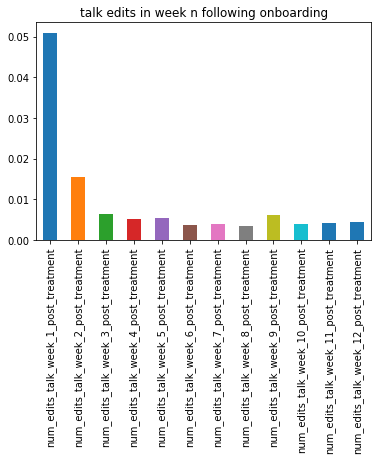

In [33]:
users.describe().loc['mean'][-12:].plot(title='talk edits in week n following onboarding',kind='bar') #num_edits_talk_week_1_post_treatment

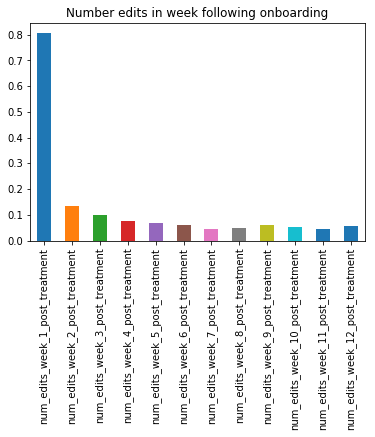

In [34]:
users.describe().loc['mean'][3:15].plot(title='Number edits in week following onboarding',kind='bar') #num_edits_week_1_post_treatment

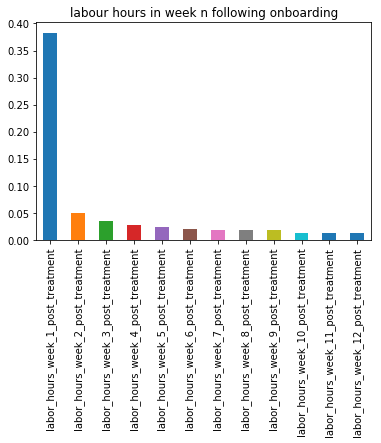

In [35]:
users.describe().loc['mean'][15:27].plot(title='labour hours in week n following onboarding',kind='bar')  #labor_hours_week_1_post_treatment 

# Specific pages

In [36]:
def page_ids_of_signatories():
    con.execute("use frwiki_p;")
    sig_sql = """
                select p.page_title, p.page_id, p.page_namespace from
                (select user_name from 
                (select distinct(r.rev_user) from
                (select * from page where page_title = 'Aide_et_accueil/Signatures') s
                join revision r
                on s.page_id = r.rev_page) signatories
                join user u
                 on signatories.rev_user = u.user_id) signatories_user
                join page p
                on p.page_title = signatories_user.user_name
                where p.page_namespace in (2,3)
                ;"""
    sig_df = pd.read_sql(sig_sql, con)
    return sig_df

In [37]:
# forum_des_nouveaux_page_id = 8284195
# forum_des_nouveaux_talk_page_id = 8338403
# forum_des_nouveaux_page_ids = (forum_des_nouveaux_page_id, forum_des_nouveaux_talk_page_id)

In [40]:
sig_df = page_ids_of_signatories()

In [41]:
sig_page_ids = sig_df['page_id'].tolist()

In [42]:
def edits_page_in_first_week(target_page_ids, start_date, rev_dict):
    end_date = start_date + td(days=7)
    first_week_revs = [r for r in rev_dict if r['rev_timestamp'] < end_date]
    first_week_target_revs = [r for r in first_week_revs if r['rev_page'] in target_page_ids]

    return True if len(first_week_target_revs) > 0 else False

In [43]:
users['response_rate_personalization_7_post_treatment'] = users.apply(lambda row: \
                                                                      edits_page_in_first_week(sig_page_ids, 
                                                                                               row['user_registration'],
                                                                                               row['revs_90_after_sim_onboard']) ,axis=1)
# users['response_rate_nouveaux_7_post_treatment'] = users.apply(lambda row: \
#                                                                       edits_page_in_first_week(forum_des_nouveaux_page_ids, 
#                                                                                                row['user_registration'],
#                                                                                                row['revs_90_after_sim_onboard']) ,axis=1)


## read flowdump output

In [35]:
!wget http://isalix.hestia.feralhosting.com/fr_user_ids_posting_forum_des_nouveaux_201811280.csv

--2018-11-28 23:52:26--  http://isalix.hestia.feralhosting.com/fr_user_ids_posting_forum_des_nouveaux_201811280.csv
Resolving isalix.hestia.feralhosting.com (isalix.hestia.feralhosting.com)... 185.21.216.138
Connecting to isalix.hestia.feralhosting.com (isalix.hestia.feralhosting.com)|185.21.216.138|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120033 (117K) [text/csv]
Saving to: ‘fr_user_ids_posting_forum_des_nouveaux_201811280.csv’

fr_user_ids_posting 100%[===================>] 117.22K   388KB/s    in 0.3s    

2018-11-28 23:52:27 (388 KB/s) - ‘fr_user_ids_posting_forum_des_nouveaux_201811280.csv’ saved [120033/120033]



In [20]:
!mkdir data/misc

In [36]:
!mv fr_user_ids_posting_forum_des_nouveaux_201811280.csv data/misc/.

In [44]:
forum = pd.read_csv('data/misc/fr_user_ids_posting_forum_des_nouveaux_201811280.csv', index_col='user_id',usecols=[1,2,3,4,5])

In [45]:
forum['all_posts'] = forum.apply(sum,axis=1)

In [46]:
forum.reset_index(inplace=True)

In [47]:
forum['response_rate_nouveaux_newquestion_post_treatment'] = forum['newquestion']
forum['response_rate_nouveaux_allposts_post_treatment'] = forum['all_posts']

In [48]:
users = users.merge(forum[['user_id','response_rate_nouveaux_newquestion_post_treatment', 'response_rate_nouveaux_allposts_post_treatment']],how='left')

In [49]:
users = users.fillna(0)

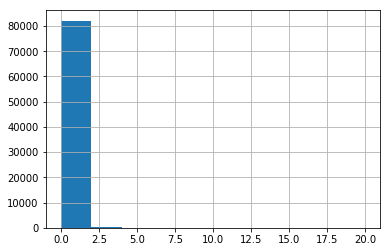

In [50]:
users['response_rate_nouveaux_allposts_post_treatment'].hist()

In [53]:
users['response_rate_nouveaux_newquestion_post_treatment'].mean()

0.0030738949772799065

In [4]:
users['response_rate_nouveaux_allposts_post_treatment'].mean()

0.009495476898791816

In [5]:
users['response_rate_nouveaux_allposts_post_treatment'].max()

20.0

In [6]:
users['response_rate_nouveaux_allposts_post_treatment'].median()

0.0

In [7]:
did_msg = users[users['response_rate_nouveaux_allposts_post_treatment']>0]

In [10]:
did_msg['response_rate_nouveaux_allposts_post_treatment'].median()

2.0

In [ ]:
# DOESNT WORK BECAUSE OF FLOW# users['response_rate_nouveaux_7_post_treatment'].value_counts()

In [52]:
users['response_rate_personalization_7_post_treatment'].value_counts()

False    82098
True       208
Name: response_rate_personalization_7_post_treatment, dtype: int64

In [ ]:
# THIS is an attempt to get flow through the API, saving through prosperity.
# import requests

# int(sim_onboard_start_date.strftime('%Y%m%d%H%M%S'))

# frbase = 'https://fr.wikipedia.org/w/api.php?'
# flow_params={'action':'flow',
#             'submodule':'view-topiclist',
#              'vtlsortby':'updated',
#              'format':'json',
#              'vtllimit':'10',
#              'vtloffset-dir':'rev',
#              'vtloffset':sim_onboard_start_date.strftime('%Y%m%d%H%M%S'),
#             'page':'Wikipédia:Forum_des_nouveaux',
#             }

# tl_resp = requests.get(frbase, params=flow_params)
# print(tl_resp.url)
# # next_page = tl_json['flow']['view-topiclist']['result']['topiclist']['links']['pagination']['fwd']['url']

# tl_json = tl_resp.json()

# tl_json

In [54]:
users.to_pickle('checkpoints/fr_users_name_flow.pickle')

In [15]:
users = pd.read_pickle('checkpoints/fr_users_name_flow.pickle')

## Get DRAFTs
- first get all drafts
- split on slash, get user prefix

In [16]:
con.execute('use frwiki_p;')
brouillons = pd.read_sql(r'select page_id as draft_page_id , page_title as draft_page_title from page where page_title like "%%/Brouillon%%" and page_namespace = 2;', con)

In [17]:
brouillons['draft_page_title'] = brouillons['draft_page_title'].apply(decode_or_nouser)

In [18]:
brouillons['user_name'] = brouillons['draft_page_title'].apply(lambda x: x.split('/')[0])

In [34]:
users = users.merge(brouillons, how='left')

In [36]:
def draft_page_edit_in_window(rev_list, draft_page_id, register_date, window=None):
    if window:
        end_date = register_date + td(days=window)
        rev_list = [r for r in rev_list if r['rev_timestamp']<end_date]
    return draft_page_id in [r['page_id'] for r in rev_list]

In [40]:
#note a bit of extra processing is needed to make thes response_rate_draft_7_post_treatment, i should have got the page id
users['response_rate_draft_any_post_treatment'] = users.apply(lambda row: draft_page_edit_in_window(row['revs_90_after_sim_onboard'],
                                                                                               row['draft_page_id'],
                                                                                               row['user_registration'],
                                                                                               window=None) , axis=1)
users['response_rate_draft_7_post_treatment'] = users.apply(lambda row: draft_page_edit_in_window(row['revs_90_after_sim_onboard'],
                                                                                               row['draft_page_id'],
                                                                                               row['user_registration'],
                                                                                               window=7) , axis=1)

In [43]:
users['response_rate_draft_7_post_treatment'].mean()

0.016258879242304656

In [11]:
users['response_rate_draft_7_post_treatment'].value_counts()

False    81016
True      1339
Name: response_rate_draft_7_post_treatment, dtype: int64

## Activation
day_N_activation_namespace_K_post_treatment
(binary) if the user made a namespace edit on the Nth day (1-indexed) of their registration (UTC is reasonable for most francophone countries)
N=1,2,7
K={0,≠0}


In [54]:
Ns = [1,2,7]
Ks = {'0':lambda l: len([p for p in l if p['page_namespace'] == 0])>0,
      'non_0':lambda l: len([p for p in l if p['page_namespace'] != 0])>0}

for N in Ns:
    for K_lab, K_fun in Ks.items():
        col_name = f'day_{N}_activation_namespace_{K_lab}_post_treatment'
        print(col_name)
        
        days_after_observation_start = 0 #starting on the same day as observation 
        days_after_observation_end = N

        
        ts_N = f'ts_in_day_{N}'

        users[ts_N] = users.apply(lambda row: ts_in_week(row['revs_90_after_sim_onboard'],
                                                            row['user_registration'],
                                                            days_after_observation_start,
                                                            days_after_observation_end), axis=1)

        #         date_start =  + td(days=days_after_treat_start)
#         date_end =  + td(days=days_after_treat_end)

        users[col_name] = users[ts_N].apply(K_fun)
    
        del users[ts_N]


day_1_activation_namespace_0_post_treatment
day_1_activation_namespace_non_0_post_treatment
day_2_activation_namespace_0_post_treatment
day_2_activation_namespace_non_0_post_treatment
day_7_activation_namespace_0_post_treatment
day_7_activation_namespace_non_0_post_treatment


In [55]:
users[users.columns[-6:]].mean()

day_1_activation_namespace_0_post_treatment        0.174586
day_1_activation_namespace_non_0_post_treatment    0.064246
day_2_activation_namespace_0_post_treatment        0.176966
day_2_activation_namespace_non_0_post_treatment    0.066711
day_7_activation_namespace_0_post_treatment        0.182709
day_7_activation_namespace_non_0_post_treatment    0.072685
dtype: float64

In [57]:
users.columns.values

array(['user_id', 'user_name', 'has_email', 'has_gender',
       'user_registration', 'sim_observation_end',
       'revs_90_after_sim_onboard', 'labour_hours_90_post_treatment',
       'num_edits_90_post_treatment', 'num_edits_week_1_post_treatment',
       'num_edits_week_2_post_treatment',
       'num_edits_week_3_post_treatment',
       'num_edits_week_4_post_treatment',
       'num_edits_week_5_post_treatment',
       'num_edits_week_6_post_treatment',
       'num_edits_week_7_post_treatment',
       'num_edits_week_8_post_treatment',
       'num_edits_week_9_post_treatment',
       'num_edits_week_10_post_treatment',
       'num_edits_week_11_post_treatment',
       'num_edits_week_12_post_treatment',
       'any_edits_week_1_post_treatment',
       'any_edits_week_2_post_treatment',
       'any_edits_week_3_post_treatment',
       'any_edits_week_4_post_treatment',
       'any_edits_week_5_post_treatment',
       'any_edits_week_6_post_treatment',
       'any_edits_week_7_post_t

In [59]:
cols_not_to_save = ['sim_observation_end',
                   'revs_90_after_sim_onboard',
                    'draft_page_id',
       'draft_page_title', 'response_rate_draft_post_treatment','response_rate_draft_any_post_treatment',]
cols_to_save = [c for c in users.columns if not c in cols_not_to_save]

In [63]:
users[cols_to_save].to_csv('outputs/french_power-analysis_dataset_sim_date_{0}_v1.csv'.format(sim_onboard_start_date.strftime('%Y%m%d')),index=False)

In [3]:
users = pd.read_csv('outputs/french_power-analysis_dataset_sim_date_20180307_v1.csv')